# Exercise Sheet 1 – Deep Learning with PyTorch

 * Deep Learning – Winter term 2021/22
 * Instructor: Alexander Ecker
 * Tutors: Max Burg, Laura Pede
 * Due date: Nov 9, 2021 at noon


# IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

Implementation
- Do not change the cells which are marked as "Do not change", similarly write your solution to the marked cells.


# Introduction

In this task you will get to know the basic tools used by the machine learning community.
Later, we will build a logistic regression model with PyTorch and perform training and prediction on the MNIST dataset.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:

*   [Pytorch Tutorial](https://pytorch.org/tutorials/)
*   [Seaborn Tutorial](https://seaborn.pydata.org/tutorial.html)


## Imports

Jupyter notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [76]:
import random
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import torch
import pathlib
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import fastprogress

## System checks

Perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)?

In [77]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.

Go to Edit -> Notebook settings -> Select GPU as Hardware accelerator.

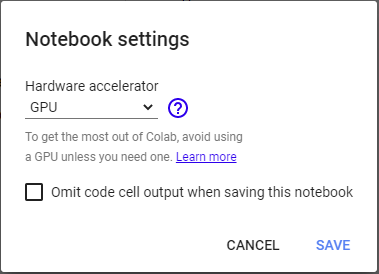

Now check the availability again.

In [78]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

Choose your device for computation. CPU or one of your CUDA devices?

In [79]:
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

# PyTorch: getting to know tensors

PyTorch is a library for deep learning on arbitray datasets, including irregular input data such as graphs, point clouds and manifolds. 

In this short tutorial we will explore some of its features to handle data in tensors. 
If you want to, you can look into more [detailed PyTorch tutorials](https://pytorch.org/tutorials/) online.

In [80]:
# create numpy array
numpyarray = np.arange(10).reshape(2, 5)
# convert to pytorch tensor
a = torch.from_numpy(numpyarray)

Let us find out what the properties of this tensor 'a' are.

In [81]:
# TODO print the tensor
print(a)

In [82]:
# TODO print its type
print(a.type())

In [83]:
# TODO print its shape
print(a.shape)

In [84]:
# TODO print its size
print(a.size()) # same as shape. Shape was added to mimic NumPy

In [85]:
# TODO create a new numpy array out of the tensor and print its size
a_np = a
a_np = a_np.numpy()
print(a_np.shape)
print(a_np.size)

Let's create some new tensors.

In [86]:
# TODO create tensor (2,5) filled with ones of type int and print it
x = torch.ones([2,5], dtype = int)
print(x)

In [87]:
# TODO create tensor (3,4) filled with zeros and print it
x = torch.zeros([3,4])
print(x)

In [88]:
# TODO transpose a
a_t = torch.transpose(a,0,1)
print(a_t.size())

Now change a value in the numpy array. Does the corresponding tensor change?

In [89]:
# TODO change value in numpy array and inspect the tensor a
print("old values of the array: ")
print(numpyarray)
print("Old values of the tensor")
print(a)
numpyarray[0,0] = 7
print("new values of the array: ")
print(numpyarray)
print("new values of the tensor:")
print(a)

Yes

Does it work the other way round as well?

Yes

In [90]:
# create numpy array
numpyarray = np.arange(10).reshape(2, 5)
# convert to pytorch tensor
a = torch.from_numpy(numpyarray)
print("old values of the array: ")
print(numpyarray)
print("Old values of the tensor")
print(a)
a[0,0] = 4
print("new values of the array: ")
print(numpyarray)
print("new values of the tensor:")
print(a)

Now we want to make use of the different devices available, namely cpu and gpu. 

In [91]:
# TODO move 'a' to the gpu
cuda = torch.device('cuda:0') 
a_gpu = torch.tensor(a, device = cuda);
a[0,0] = 9
print("GPU Tensor after CPU tensor has been changed:")
print(a_gpu)
print("Changed CPU tensor")
print(a)

If you change a value in the tensor 'a' now, does the corresponding value in the tensor on the GPU change as well?
No

# Deep Learning with Pytorch

The process of training and evaluating a deep learning model begins with **data loading**.
A dataset needs to be chosen on which the model should be trained.
This data might need some preprocessing like resizing or normalizing of images.
Splitting of the data in different sets is necessary. We need a set to train on, a set to validate the training progress and a set to test the model after training.

The next step is to **specify the model and its optimizer**, as well as the loss function.
An important hyperparameter is the learning rate which influences how big the changes of the parameters should be after calculating the loss.

The **model fitting** is split into training and evaluation.
In the training process the model does a forward pass which means the data is presented to the model and the model outputs a prediction.
The loss compares the prediction with the ground truth.
In the backward pass the gradient with regard to the parameter is calculated and the parameter are updated by the gradient step.
In the evaluation process the loss is computed on the entire validation set.
This is done to see how well the model operates on data for which the params were not optimized before in order to avoid overfitting.
The model fitting process is repeated for `N` epochs which is another hyperparameter that needs to be chosen carefully.

After the training we evaluate the final model on the test set.

We'll go through the individual steps in the course of this notebook.


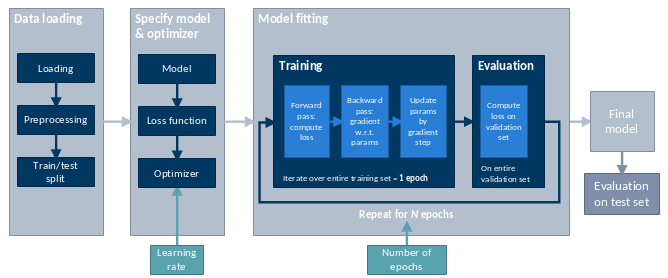

## Data loading

### Loading the MNIST Dataset
This dataset contains handwritten digits, and it is widely used by the machine learning community. It's really useful that you get accustomed with this dataset, as you'll come across later under other concepts. 

The first thing you should always do when you begin to work with a data set that you have not used before is to play around with it to get a better understanding of its properties.

**Download** the train split of the MNIST dataset using torchvision dataset classes.

In [92]:
data_dir = pathlib.Path('data/')
mnist = datasets.MNIST(data_dir, download=True, train=True)

Let's check the first ten samples to see what they look like

In [93]:
X_sample, y_sample = mnist[0]
# TODO: display the label and the image
plt.title("label: "+str(y_sample))
plt.axis('off')
plt.imshow(X_sample, cmap='gray');

Look at the types of X and y.

In [94]:
# TODO: display types
print("Type of X:")
print(type(X_sample))
print("Type of y:")
print(type(y_sample))

How many data points are there in the dataset?

In [95]:
# TODO: print out the length of the dataset
print(len(mnist))

In [96]:
N = 10
fig, axes = plt.subplots(1, N, figsize=(2*N, 2))
X, y = mnist.data, mnist.targets
for ax, image, label in zip(axes.ravel(), X, y):
  ax.set_title("label: {}".format(label))
  ax.axis('off')
  ax.imshow(image.reshape(28,28), cmap='gray') # Remember, images are 28x28

The following plots show more information about the dataset:
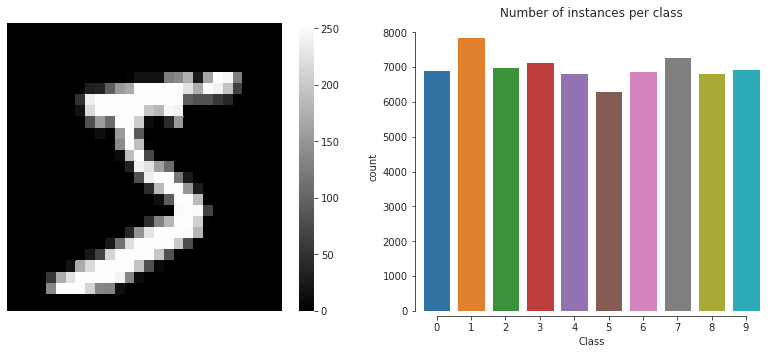


Now that you know what MNIST looks like, you can guess what the task you can do with the dataset is: classifying handwritten digits.

### Preprocessing the data

#### Transformation

We have seen above that the contents of the data set are of type [(PIL.Image.Image, Int)]. However, pytorch (the core that is, not torchvision or torchtext) is only equipped to work on Tensor objects. So we need to **transform** _PIL.Image.Image_ to _torch.Tensor_. Torchvision takes care of that for us. _transforms.ToTensor_ is a transformation operation that maps a _PIL.Image.Image_ to a torch tensor.

In [97]:
mnist = datasets.MNIST(data_dir, download=True, train=True, transform=transforms.ToTensor())

#### Normalization


Furthermore, we will **normalize** the data to zero-mean and unit-variance. _transforms.Normalize_ takes the mean and std-dev for each channel and rescales the data to zero-mean, unit-variance. 

See https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize for more information.

We can combine multiple transformations via _transforms.Compose_.

So let's create a new dataset that we will be using for testing purposes with those transformations in-place.


In [98]:
tmp_dataloader = torch.utils.data.DataLoader(mnist, batch_size=len(mnist), shuffle=True)

In [99]:
# TODO calculate mean and standard deviation of MNIST train dataset
data = next(iter(tmp_dataloader))
mean = data[0].mean()
std = data[0].std()

In [100]:
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

### Training, Validation and Test Sets

For the correct fitting of a neural network model we need three datasets: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data. 

Note that you should not use the test set in any part of your training and model selection procedure. It should be only used for showing the final results.

We first need to **load** the datasets.
Above, we did that already to visualize the data and calculate normalization values.
Now we load them and **apply the normalization transform** in this process.

In [101]:
# TODO download the dataset for training and testing, with normalization transform
mnist_train = datasets.MNIST(data_dir, download=True, train=True, transform=mnist_transforms)
mnist_test = datasets.MNIST(data_dir, download=True, train=False, transform=mnist_transforms)

We need to **split** the train dataset in two sets, one for training and one for validation. 
While the training set needs to be quite large, the validation set can be relatively small.
Take 10 % of the dataset as validation set.
Assign samples *randomly* to the training and validation set, using a fixed seed to ensure reproducibility.

In [102]:
# TODO split the train dataset in mnist_train and mnist_val
print(len(mnist_train))
size_val = int(len(mnist_train)*0.1)
size_train = len(mnist_train)-size_val
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [size_train,size_val], generator=torch.Generator().manual_seed(42))

print(len(mnist_train))
print(size_train)
print(size_val)

To load the data for model training, we need to define the **dataloaders**.
A dataloader represents a Python iterable over a dataset and draws mini batches with random samples.
Use the batch size as specified above.
Make sure we get shuffled samples in batches.

In [103]:
batch_size = 256

In [104]:
# TODO create dataloader for training, validation and test
train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(mnist_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

Let's get a data point now to see what we're dealing with. 

For this, you might want to check out how python's iterator protocol works. It's simple and will give you an important insight into python: https://wiki.python.org/moin/Iterator.

In [105]:
# TODO display an element of the train_dataloader
figure = plt.figure(figsize=(8, 8))
train_iter = iter(train_dataloader)
images, labels = train_iter.next()
plt.title(labels[0])
plt.axis("off")
plt.imshow(images[0].squeeze(), cmap="gray");

In [106]:
# TODO display the dimensions of x and y
print(images.shape)
print(labels.shape)

x has size (\[batchsize\], 1, 28, 28) --> 256 batches (or whatever you have defined in your data loader), 1 channel (the images are monochrome), and the dimensions of the images are 28 height/rows and 28 width/cols.

y has size (\[batchsize\]) --> 256 images (again depends on your data loader config). There's one label for each of the images in the batch.

## Specify model & optimizer

### Specify a model

The task is now to define a model to train on the data. In this simple example, we only need **one fully-connected layer** as defined in *torch.nn.Linear* that produces a predicted label for a specific training image.

Before, we set some variables: 
- the input and output size of the linear layer
- how long we want to train the model (number of epochs) and 
- the learning rate.


In [107]:
epochs = 1
input_dim = 28 * 28
output_dim = 10
lr = 0.001

In [108]:
class LogisticRegression(torch.nn.Module):
    """
    Logistic regression model
    inherits the torch.nn.Module which is the base class 
    for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LogisticRegression, self).__init__()
        # TODO define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim, device='cuda:0', dtype=None)
        
    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        #784*1
        # TODO flatten the input to a suitable size for the initial layer
        x = x.view(x.shape[0],-1)
        # TODO run the data through the layer
        outputs = self.linear(x)
        return outputs

### Instantiate the model

Let us instantiate the model and take a look at the inside. It is always a good idea to verify that the actual architecture is what you intended it to be. Especially, when you start to create layers dynamically it is great for inspection/verification/debugging.

In [109]:
# TODO instantiate the model
model = LogisticRegression(input_dim, output_dim)


In [110]:
print(model)

Move the model to the GPU if available.

In [111]:
# TODO move model to device you specified above
model = model.cuda()

Put the model in training mode.

In [112]:
# TODO put the model in train mode
model.train()

### Define a loss function

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in [0, 1] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

**Hint** Due to numerical reasons, softmax and cross entropy are combined to operate more stable. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [113]:
# TODO define loss function
loss_function = torch.nn.CrossEntropyLoss() 

### Define the optimizer

The optimizer is the learning algorithm we use. In this case, we use Stochastic Gradient Descent (SGD).

In [114]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## Model fitting

### Train the model

Everything is set for the model to train!

- In the forward pass, the prediction is made using the previously defined model on the images of the dataloader.
- Then the loss (or error) needs to be computed by comparing the prediction to the actual label.
- In the backward pass, the model learns and updates its weights based on the current gradient.

In [115]:
# TODO fill in the missing lines
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # delete the gradients from last training iteration
        images = images.to('cuda')
        labels = labels.to('cuda')
        #optimizer.zero_grad()

        # Forward pass: get predictions
        y_pred = model(images)

        # Compute loss
        loss = loss_function(y_pred,labels)
        

        # Backward pass -> calculate gradients, update weights
        loss.backward()
        optimizer.step()
        

### Make a prediction

Now that our model is trained, we can make a new prediction by inputting an unseen image of the test dataset.

Run this cell several times, does the model predict accurately?

Set the number of epochs to 10 and try again!

**TODO your answer here**

In [116]:
print(images.shape)

In [117]:
# TODO get a random element of the test dataloader
figure = plt.figure(figsize=(8, 8))
train_iter = iter(train_dataloader)
images, labels = train_iter.next()
images = images[0]
label = labels[0]
plt.axis("off")
plt.imshow(images.squeeze(), cmap="gray");
# TODO set model in eval mode

# no automatic gradient update needed in evaluation
with torch.no_grad():
    # TODO make a prediction
    images = images.to('cuda')
    y_pred = model(images)

# print predicted label and given label
print("predicted label: ", y_pred.argmax().item())
print("given label: ", label.item())

### Track and plot the training and validation error and accuracy

What we have seen so far is the basic principle of training a model and making a prediction. But one might be interested to see more about the training process, for instance how the training error evolves with time and how the accuracy (hopefully) increases while training the model longer.

For this step, we are going to **refine the training process** and **add some important information saving for plotting**.

Create a plot using **seaborn** that contains both the losses on training set and the losses on the validation set for each epoch.

Create a second plot that contains both the accuracies on training set and the accuracies on the validation set for each epoch.

The plots should look similar to this:

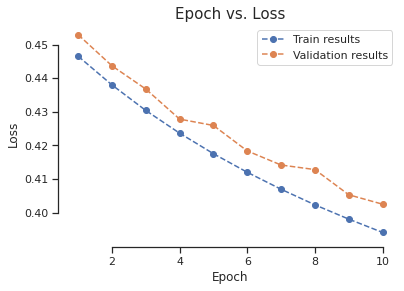 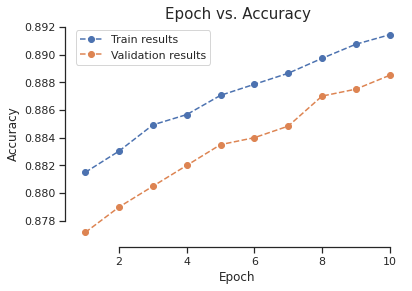

**Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind for future exercise sheets.

In [118]:
# TODO write a function that calculates the accuracy
def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    acc = 100 * correct/total
    return acc

In [119]:
# TODO refine the training function from above
# it should contain:
# - saving of losses
# - calculation of accuracy
# - returning the mean loss and accuracy
loss_ar = []
total = 0
correct = 0
acc = []
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # delete the gradients from last training iteration
        images = images.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        
        # Forward pass: get predictions
        y_pred = model(images)
        # Compute loss
        loss = loss_function(y_pred,labels)
        
        
        # Backward pass -> calculate gradients, update weights
        loss.backward()
        optimizer.step()
        
        # Calculate Accuracy
        k = 0
        loss_ar.append(loss.item())
        for k in range(len(images)):
            total += 1
            if y_pred[k].argmax().item() == labels[k].item():
                correct+= 1
                
        acc.append(accuracy(correct,total))
        #print("Batch: "+str(i)+": "+" Train Accuracy: "+str(acc)+"%")
        
        
        
print("Mean Accuracy: "+str(np.mean(acc)))
print("Mean Loss: "+str(np.mean(loss_ar)))
        

In [120]:
print(images.shape)

In [121]:
# TODO write a validation function that calculates the loss and accuracy on the validation set
# you can also combine it with the training function

def print_train():
    k=0
    loss_ar = []
    total = 0
    correct = 0
    acc = []
    for i, (images, labels) in enumerate(train_dataloader):
        # delete the gradients from last training iteration
        images = images.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
    
        # Forward pass: get predictions
        y_pred = model(images)
        # Compute loss
        loss = loss_function(y_pred,labels)
        
        
        # Backward pass -> calculate gradients, update weights
        loss.backward()
        optimizer.step()
        
        # Calculate Accuracy
        k = 0
        loss_ar.append(loss.item())
        for k in range(len(images)):
            total += 1
            if y_pred[k].argmax().item() == labels[k].item():
                correct+= 1
                
        acc.append(accuracy(correct,total))
        #print("Batch: "+str(i)+": "+" Train Accuracy: "+str(acc)+"%")
        
        
        
    print("Mean Train Accuracy: "+str(np.mean(acc)))
    print("Mean Train Loss: "+str(np.mean(loss_ar)))
    return np.mean(acc), np.mean(loss_ar)
def print_val():
    k = 0
    loss_ar = []
    total = 0
    correct = 0
    acc = []
    for images, labels in  val_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')
        y_pred = model(images)
        loss = loss_function(y_pred,labels)
        loss_ar.append(loss.item())
        for k in range(len(images)):
                total += 1
                if y_pred[k].argmax().item() == labels[k].item():
                    correct+= 1
    acc.append(accuracy(correct,total))

    print("Mean Test Accuracy: "+str(np.mean(acc)))
    print("Mean Test Loss: "+str(np.mean(loss_ar)))
    return np.mean(acc), np.mean(loss_ar)

In [122]:
# TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch

def run_training(epochs):
    acc_train = []
    loss_ar_train = []
    acc_val = []
    loss_ar_val = []
    for epoch in range(epochs):
        print("Epoch: "+str(epoch))
        a, l =  print_train() 
        acc_train.append(a)
        loss_ar_train.append(l)
        a, l = print_val()
        acc_val.append(a)
        loss_ar_val.append(l)
    return acc_train, loss_ar_train,acc_val, loss_ar_val

In [123]:
print(train_dataloader)

In [124]:
# TODO call the run_training function and run it for 10 epochs.
num_epochs = 10
at,la,av,lv = run_training(num_epochs)

In [125]:
# TODO write a plot function
def plot_graphs(d1,d2,num_epochs,acc):
    target = "Loss"
    if(acc):
        target = "Accuracy"
    name1 = "Train "+target
    name2 = "Val "+ target
    df = pd.DataFrame({'Epochs':range(num_epochs),name1:d1,name2:d2})
    print(df.head())
    df = df.melt('Epochs', var_name='Metric',  value_name=target)
    sb.catplot(x='Epochs', y=target, hue='Metric', data=df, kind='point')

In [126]:
# TODO plot losses
acc = False
plot_graphs(la,lv,num_epochs, acc)

In [127]:
# TODO plot accuracies
acc = True
plot_graphs(at,av,num_epochs, acc)

### Plot the confusion matrix

Additionally to the losses and accuracies we want to plot the confusion matrix at the end of the training procedure, to get an overview about which digits were easily predicted, and which digits were often confused for other, similar looking digits.

1.   Write a function that calculates the confusion values on the validation set.
2.   Normalize the confusion matrix and plot it using seaborn similar to the following format.

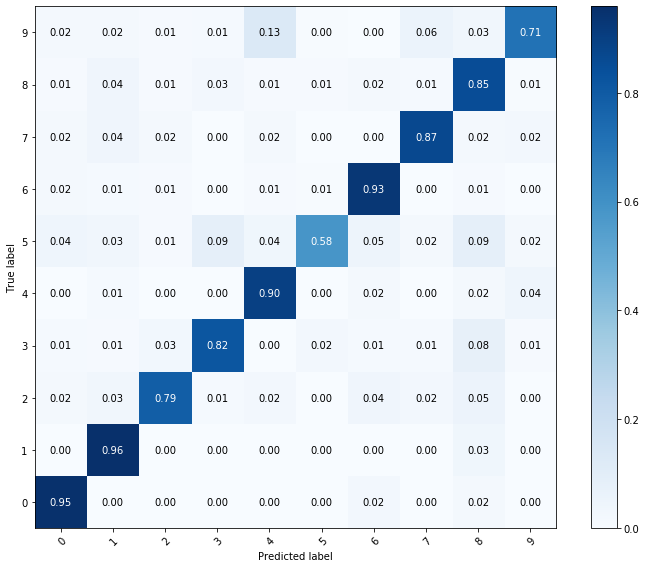

In [128]:
# TODO write a function to calculate the confusion values
nb_classes = 10
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to('cuda')
        labels = labels.to('cuda')
        y_pred = model(images)
        _, y_pred = torch.max(y_pred, 1)
        for t, p in zip(labels.view(-1),y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(range(10))
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sb.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

In [129]:
# TODO normalize and plot the confusion matrix
confusion_matrix= confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15,10))

class_names = list(range(10))
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

heatmap = sb.heatmap(df_cm, annot=True, vmin = 0, vmax = .2 )

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

Which digit is often confused for which digit?

[](http://)

5 and 3
